Data Load

In [ ]:
!pip install gdown
!gdown --id 1AnlrBVYEb9c2SuL8ZZfSg460qv62sUYy -O GermPredDataset.zip
!unzip GermPredDataset.zip

1. Import Required Libraries

In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Define Paths and Classes

In [8]:
DATASET_DIR = "GermPredDataset"
CLASSES = ["PennisetumGlaucum", "SecaleCereale", "ZeaMays"]
IMG_SIZE = (128, 128)


For Classification (Simpler — Common for Germination Prediction)

In [9]:
images = []
labels = []

for cls in CLASSES:
    img_folder = os.path.join(DATASET_DIR, cls, "img")
    for img_name in os.listdir(img_folder):
        if img_name.endswith(".jpg"):
            img_path = os.path.join(img_folder, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, IMG_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(cls)

images = np.array(images, dtype="float32") / 255.0  # Normalize
labels = np.array(labels)


For Detection/Localization

In [10]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        boxes.append([label, xmin, ymin, xmax, ymax])
    return boxes


Encode Labels for Classification

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(labels)
y = to_categorical(y, num_classes=len(CLASSES))


Train-Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    images, y, test_size=0.2, random_state=42, stratify=y
)


Data Augmentation

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_gen = val_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)


Save Preprocessed Data (Optional)

In [14]:
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)


Verify Dataset

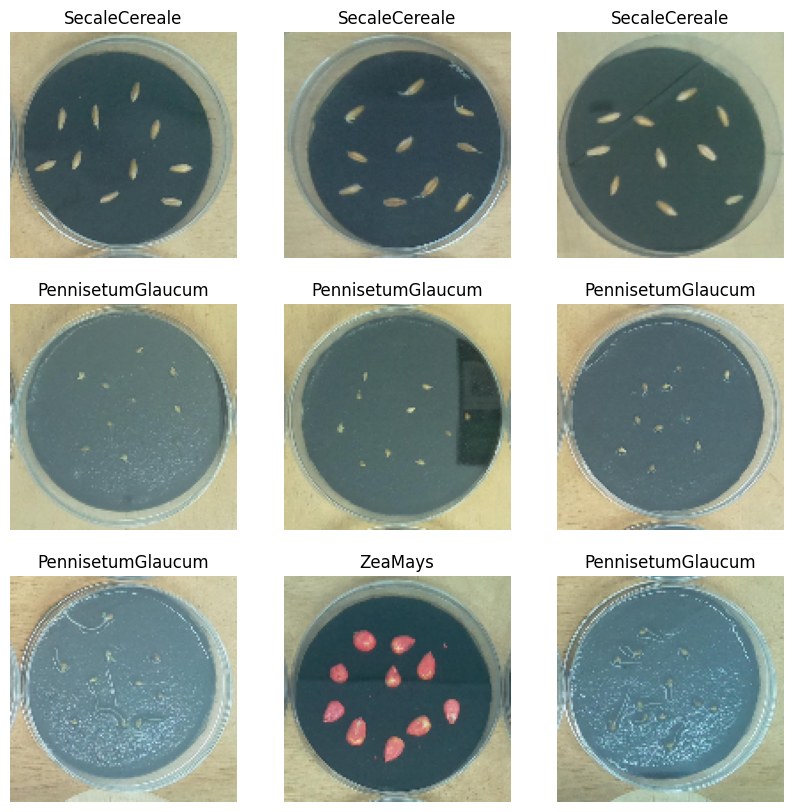

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title(CLASSES[np.argmax(y_train[i])])
    plt.axis("off")
plt.show()
